# Proper way to plot electical fields 

I've been browsing old notebooks I have and saw this notebook made way-back-when. Looking around the net there are many like it and many suffered from the same problem. namely an field line has very precise definition and its not being respected. So as with any pet-peeve issues people take I have decided to fix mine up and show how its usually done and how it should be. 

In [2]:
from scipy.integrate import ode
import numpy as np

from matplotlib import rc
import matplotlib.pyplot as plt

%matplotlib inline

rc('figure', figsize=(8,5))

General approach is to take the field of a point charge

$$E_i = \frac{1}{4\pi\epsilon_0}  \frac{q_ir_i}{r_i^2}$$

separate it in 2D Cartesian plane coordinates to:

$$E_i = \frac{1}{4\pi\epsilon_0}\frac{q_ir_x}{(r_x+r_y)^{3/2}}$$

$$E_i = \frac{1}{4\pi\epsilon_0}  \frac{q_ir_y}{(r_x+r_y)^{3/2}}$$

and then, using the fact that their x and y indices in the array act as the charge coordinates, calculate total electrical field:

$$E_i(x, y) = \frac{1}{4\pi\epsilon_0}  \sum E_i(x, y)$$

in all points on the meshgrid representing the 2D Cartesian plane.

In [3]:
class Charge:
    """
    Class representing a single charged particle. 
    charge class is consisted of a charge value q
    and a tuple representing coordinates of the charged particle.
    """
    def __init__(self, q, pos):
        """
        Send (q, pos) where q is a float value representing charge
        and pos is a tuple of coordinates (x,y)
        """
        self.q=q
        self.pos=pos
 
def E_point_charge(q, a, x, y):
    """Calculate the contribution of a single charge q located in point a
    in some other point (x, y).
    Returns a tuple (E_x, E_y)
    """
    return q*(x - a[0]) / ((x-a[0])**2 + (y-a[1])**2)**(1.5), \
           q*(y - a[1]) / ((x-a[0])**2 + (y-a[1])**2)**(1.5)
 
      
def E_total(x, y, charges):
    """Sum the contributions of all charges in the system acting on 
    a point (x, y).
    """    
    Ex, Ey=0, 0
    for C in charges:
        E  = E_point_charge(C.q, C.pos, x, y)
        Ex = Ex+E[0]
        Ey = Ey+E[1]
    return [Ex, Ey]

So far so good, very much the standard. The problem usually appears in plotting.

In [4]:
def plot_charges(charges, xspan=(-2,2), yspan=(-2,2), npoints=2000):
    """Evaluate total contributions of all charges on all points of a meshgrid
    representing the 2D Cartesian plane and plot their streamplot.
    """
    #get a location grid in place.
    x= np.linspace(xspan[0], xspan[1], npoints)
    y= np.linspace(yspan[0], yspan[1], npoints)
    
    #get actual points in which we'll calc our E field.
    x, y = np.meshgrid(x, y) #create a meshgrid from the 2k equaly spaced points 
                          #basically, match appropriate x's and y's
        
    Ex, Ey = E_total(x, y, charges) #calc the actual field values 

    plt.streamplot(x, y, Ex, Ey, color='k') #and draw the lines

    # plot point charges (circles/dots)
    for C in charges:
        if C.q>0:
            plt.plot(C.pos[0], C.pos[1], 'bo', ms=8*np.sqrt(C.q))
        if C.q<0:
            plt.plot(C.pos[0], C.pos[1], 'ro', ms=8*np.sqrt(-C.q))

    plt.gca().set_xlim(xspan[0], xspan[1])
    plt.gca().set_ylim(yspan[0], yspan[1])
    plt.show()

If hints so far haven't worked lets look at couple of plots and that might give a better idea of what's the problem.

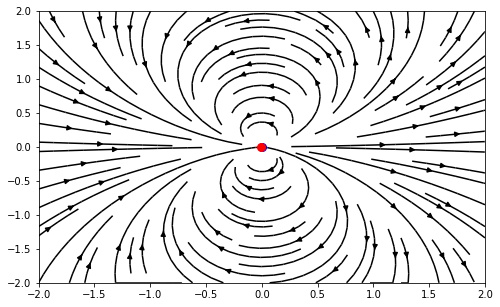

In [7]:
# charges and positions
#DIPOLE
charges=[Charge(1, [0.005, 0]), Charge(-1, [-0.005, 0])]
plot_charges(charges)

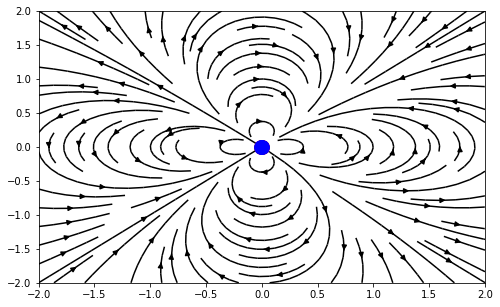

In [8]:
#QUADRIPOLE
charges=[Charge(-3, [0.005, 0.005]), Charge(-3, [-0.005, -0.005]), 
         Charge(3, [-0.005, 0.005]), Charge(3,  [0.005, -0.005]) ]

plot_charges(charges)

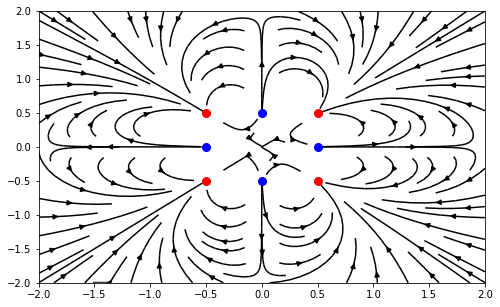

In [9]:
#OCTUPOLE
charges=[Charge(-1, [0.5,  0.5]), Charge(-1, [-0.5, -0.5]), 
         Charge(-1, [-0.5, 0.5]), Charge(-1, [0.5,  -0.5]),
         Charge( 1, [0,    0.5]), Charge( 1, [0,    -0.5]), 
         Charge( 1, [-0.5, 0]),   Charge( 1, [0.5,   0]) ]
plot_charges(charges)

If its not clear by now, the problem is that electic field lines are usually described as lines that connect two charges or extend to infinity. And that convention generally isn't followed due to inconvenience of getting it to work properly. That makes for some slightly messy plots where the symmetry of the system is not nicely visible.


## Solution 

The solution to the problem is solving for the streamlines. From the definition of the streamline, as a line that is everywhere parralel to the electric field vector, for an small move $d\vec{s} = dx\hat i + dy \hat j$ and a field $\vec E = E_x\hat i + E_y \hat j$ we have:

$$d\vec s \times \vec E = 0$$

but $\hat k$ direction is identically zero because we're only looking 2D so:

$$\frac{dy}{dx} = \frac{E_x}{E_y}$$

Which is an ODE for which we need to specify the values of $\vec E$ in all points. Starting from a charge then we can integrate in a circle around it, if the integration hadn't failed we shift to the new point $(x_0+dx, y_0+dy)$ and integrate in a circle around it, and so on ad nauseum **untill** we either reach the edge of the plot or another charge. 

Another way, I believe, to think about this is to draw a comparison with pathlines. Pathlines should be describing paths on which particles actually move. However, realizing that we are looking at static charges, so there is some invisible force holding them in place, and imagining a test charge that doesn't disturb the system but can move freely we can draw the paths that test particle will move on. Since the test particle doesn't disturb the system, just observe, we are in steady state regime in which streamlines pathlines and steaklines all coincide. Then from the definition of a pathline we have:

$$E_{i+1}(r) = E_i(r_0) + \int_{r_{0}}^r \dot E(r')dr'$$

Think of that equation as if $E$ is some coordinate x of a particle and $\dot E$ is the velocity field there. If we let a small $dt$ pass, that particle will move as if that velocity field was constanly acting on it during the $dt$ and move by $ds=vdt$. 

So lets write a new function, one that will get us the normalized values of $E$ field at a point $(x, y)$:

In [24]:
def E_norm(t, y, charges):
    """Returns normalized values of electric field at a point (x, y)."""
    Ex, Ey = E_total(y[0], y[1], charges)
    n = np.sqrt(Ex**2+Ey**2)
    return [Ex/n, Ey/n]

And lets write the ODE solver and plotter:

In [32]:
def solve_fieldlines(func, charges, xspan=(-2,2), yspan=(-2,2), pointstep=0.001):
    """Solves the dy/dx = E_x/E_y ODE of a given func."""
    for C in charges:
        # plot field lines starting in current charge
        dt=0.8*pointstep
        if C.q<0:
            dt=-dt

        # loop around current charge C and integrate  
        # loop over field lines starting in different directions 
        # to get the next step
        for alpha in np.linspace(0, 2*np.pi*15/16, 16):
            #set up the ODE func that needs to be solved
            #this is the func that'll get integrated
            r=ode(func)
            r.set_integrator('vode')
            r.set_f_params(charges)

            x=[ C.pos[0] + np.cos(alpha)*pointstep ]
            y=[ C.pos[1] + np.sin(alpha)*pointstep ]
            r.set_initial_value([x[0], y[0]], 0)

            while r.successful():
                #integrate to get every next step 
                r.integrate(r.t+dt)
                x.append(r.y[0])
                y.append(r.y[1])
                hit_charge=False
                # check if field line left drawing area or ends in some charge
                # if the next step has landed on a charge, or has exited the 
                # drawing area, stop integrating
                for C2 in charges:
                    if np.sqrt( (r.y[0] - C2.pos[0])**2 + (r.y[1] - C2.pos[1])**2 ) < pointstep:
                        hit_charge=True
                if hit_charge or ( not (xspan[0] < r.y[0] and r.y[0] < xspan[1]) ) or \
                                 ( not (yspan[0] < r.y[1] and r.y[1] < yspan[1]) ):
                    break
            #plot whatever is located in the x and y 
            plt.plot(x, y, '-k')
 
        # plot point charges
        for C in charges:
            if C.q>0:
                plt.plot(C.pos[0], C.pos[1], 'bo', ms=8*np.sqrt(C.q))
            if C.q<0:
                plt.plot(C.pos[0], C.pos[1], 'ro', ms=8*np.sqrt(-C.q))

        plt.gca().set_xlim(xspan[0], xspan[1])
        plt.gca().set_ylim(yspan[0], yspan[1])
    plt.show()

# Look at how pretty the plots are now.

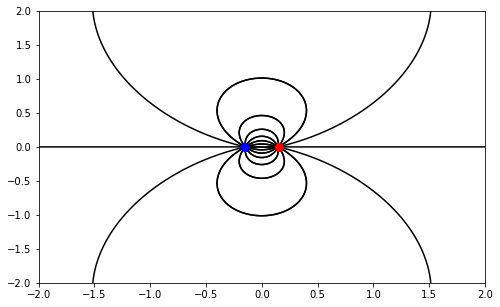

In [33]:
# charges and positions
#DIPOLE
charges=[Charge(1, [-0.15, 0]), Charge(-1, [0.15, 0]) ]
solve_fieldlines(E_norm, charges)

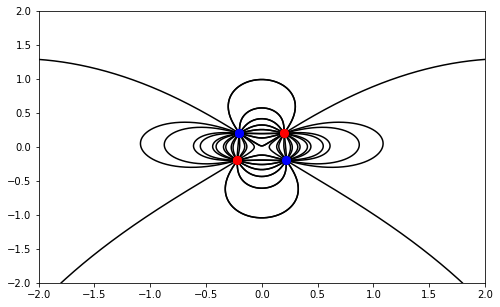

In [34]:
#QUADRIPOLE
charges=[ Charge(-1, [0.2, 0.2]),  Charge(-1, [-0.22, -0.2]), 
          Charge( 1, [-0.2, 0.2]), Charge( 1, [0.22, -0.2]) ]
solve_fieldlines(E_norm, charges)

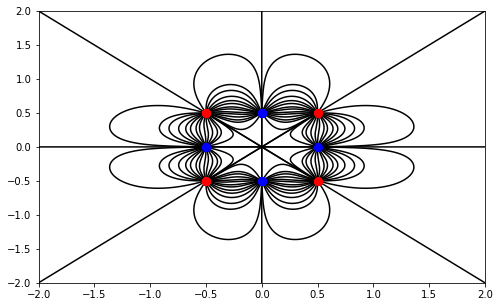

In [36]:
#OCTUPOLE
charges=[Charge(-1, [0.5,  0.5]), Charge(-1, [-0.5, -0.5]), 
         Charge(-1, [-0.5, 0.5]), Charge(-1, [0.5,  -0.5]),
         Charge( 1, [0,    0.5]), Charge( 1, [0,    -0.5]), 
         Charge( 1, [-0.5, 0]),   Charge( 1, [0.5,   0]) ]
solve_fieldlines(E_norm, charges)